In [1]:
# need to use updated master JupiterCVML code
import sys
# sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')

import os
os.environ["BRT_ENV"] = 'prod'
import json
import random
import brtdevkit
print(brtdevkit.__version__)
brtdevkit.log = 'info'
import os
os.environ['AWS_PROFILE'] = 'default'
USERNAME = 'li.yu'

import ast
import time
import numpy as np
import pandas as pd
from datetime import datetime, timezone

from brtdevkit.core.db.athena import AthenaClient, Table
from brtdevkit.data import Image, Dataset

# from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import *
# from aletheia_dataset_creator.config.dataset_config import *

from jupiterdata.config.dataset_config import *
from jupiterdata.utils.dataset import *

pd.set_option('display.max_columns', None)

# %matplotlib inline
%load_ext autoreload
%autoreload 2

7.16.2


/home/li.yu/anaconda3/envs/brtdevkit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" # run this on cmd: 
eval "$(/home/li.yu/anaconda3/bin/conda shell.bash hook)"
conda activate brtdevkit
brt-devkit-auth
aws sso login --profile jupiter_prod_engineer-425642425116
"""
import inspect
print(inspect.getmodule(Dataset))
print(LEFT_CAMERAS)
print(ALL_CAMERA_PAIRS_LIST)

<module 'brtdevkit.data.core.dataset' from '/home/li.yu/anaconda3/envs/brtdevkit/lib/python3.9/site-packages/brtdevkit/data/core/dataset.py'>
['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left', 'T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02']
[{'front-center-left': 'front-center-right', 'front-left-left': 'front-left-right', 'front-right-left': 'front-right-right', 'side-left-left': 'side-left-right', 'side-right-left': 'side-right-right', 'rear-left': 'rear-right', 'front-center-right': 'front-center-left', 'front-left-right': 'front-left-left', 'front-right-right': 'front-right-left', 'side-left-right': 'side-left-left', 'side-right-right': 'side-right-left', 'rear-right': 'rear-left'}, {'T01': 'T03', 'T02': 'T04', 'T05': 'T07', 'T06': 'T08', 'T09': 'T11', 'T10': 'T12', 'T13': 'T15', 'T14': 'T16', 'I01': 'I03', 'I02': 'I04'}, {'T02': 'T03', 'T06': 'T07', 'T10': 'T11', 'T14': 'T15', 'I02': 'I03'}]


In [3]:
# test_dataset = Dataset.retrieve(id='64ed2657926aefcd654e8269')
test_dataset = Dataset.retrieve(name='halo_human_in_dust_night_v2')
print(test_dataset.id)
test_df = test_dataset.to_dataframe()
print(test_df.shape)
test_df = test_df.sort_values('collected_on')
print(test_df.iloc[0].collected_on, test_df.iloc[-1].collected_on)

66acebe117648182b70bd45e


2024-08-06 07:14:07,901 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'message': 'Role token_exchange is required to make this API call', 'extra': {'role_name': 'token_exchange'}}


(14299, 215)
2024-06-04T04:58:40.143000 2024-07-30T06:25:51.854000


In [6]:
# test_dfs = []
test_dfs.append(test_df)
test_df = pd.concat(test_dfs, ignore_index=True)
test_df.shape

(14299, 215)

In [24]:
# filter by categorical labels
# test_df.iloc[2].id, test_df.iloc[2].annotation_categorical_0_properties
def has_human_vehicle(annotation_categorical_0_properties):
    for item in annotation_categorical_0_properties:
        if item['title'] == 'humans' or item['title'] == 'vehicles':
            if item['answer']['title'] == 'Yes':
                return True
    return False
test_df['has_human_vehicle'] = test_df['annotation_categorical_0_properties'].apply(lambda d: has_human_vehicle(d))
test_df.groupby('has_human_vehicle').size()

has_human_vehicle
False    2938
True      137
dtype: int64

In [26]:
df3 = test_df[test_df.has_human_vehicle == True]
df3.sample(5).id.to_list()

['66688951e03321e990bf92fa',
 '666888bfae1afeb09aa5f76e',
 '668d856f69c47508ef6298f0',
 '668d8557b0effa01ab367e67',
 '66688845075f19b508cef086']

In [5]:
print(test_df.special_notes.unique())
print(test_df.iloc[0].id, test_df.iloc[-1].id)

[nan 'Wheat Stubble Opposite Worked Passes' 'Excessive Dust Dusk'
 'Wheat Stubble Night Continuous Capture' 'Wheat Continuous capture']
667c93106793d2030492d3fc 667c9e8c17e3f789694226e4


In [4]:
test_df[['id', 'camera_location']].groupby('camera_location').size()
# test_df[['id', 'operation_time']].groupby('operation_time').size()

camera_location
T01    369
T02    369
T03    738
T04    369
dtype: int64

In [5]:
to_triage_df = pd.read_csv('/data2/jupiter/datasets/dust_datasets/halo_human_in_dust_night_v2/to_triage.csv')
print(to_triage_df.shape)
test_df = test_df[~test_df.id.isin(to_triage_df.id)]
test_df.shape

(106, 1)


(14193, 215)

## Run Databricks Query

In [11]:
# from jupiterdata.db import databricks_connector
# databricks = databricks_connector.Databricks()
# # note on json extraction https://docs.databricks.com/en/sql/language-manual/sql-ref-json-path-expression.html
# df = databricks.execute(query)
# print(df.shape, len(df)//2)

query = f"""
SELECT
  IMJ.id,
  IMJ.operation_time,
  IMJ.camera_location,
  IMJ.robot_name,
  IMJ.collected_on,
  IMJ.special_notes,
  IMJ.hard_drive_name,
  IMJ.spark_request__json,
  IMJ.teleop_request__json,
  IMJ.geohash
FROM
  mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
WHERE
  IMJ.robot_name = 'bedrock_451'
  AND IMJ.collected_on >= date('2024-07-29')
  AND IMJ.collected_on <= date('2024-07-31')
"""

query = f"""
SELECT distinct id, robot_name, camera_location, collected_on, hard_drive_name, special_notes, jdb_s3_path, gps_can_data__json
FROM mesa_prod.mesa_lake_prod.image_jupiter
WHERE robot_name like '%halohitchhiker_16%'
AND collected_on > date('2023-09-01')
AND collected_on < date('2023-12-01')
"""

  # IMJ.has_human_annotation,
  # IMJ.has_nearby_stop_event,
  # IMJ.operating_field_name,
  # IMJ.farm,
  # IMJ.bag_name,
  # IMJ.closest_object_info__json,
  # IMJ.created_at,
  # IMJ.hard_drive_name,
  # IMJ.state,
  # IMJ.hdr_mode,
  # IMJ.group_id,
  # IMJ.jdb_s3_path,
  # IMJ.ros_s3_path,
  # IMJ.bundle,
  # IMJ.gps_can_data__json,
  # IMJ.implement_angle_data__json,
  # IMJ.autonomy_state__json,
  # IMJ.sensor_type,
  # IMJ.geohash,
  # IMJ.calibration_data__json,
  # IMJ.tractor_type
  # IMJ.robot_name = 'bedrock_411'
  # AND IMJ.hard_drive_name = 'JUPD-0612_2022-1-3'
  # AND IMJ.collected_on > date('2024-04-22')
  # AND IMJ.collected_on <= date('2024-04-24')

# query = """
# SELECT id, image, properties__json FROM annotation_jupiter
# WHERE style = 'categorical'
# AND created_at > date('2024-01-01')
# AND state in ('review', 'ok')
# AND properties__json LIKE '%"title": "human\_pose"%'
# AND kind = 'labelbox'
# """

# # query for categorical labels
# query = f"""
# SELECT image AS id, properties__json, created_at FROM annotation_jupiter
# WHERE style = 'categorical'
# AND state in ('review', 'ok')
# AND label_map_full = '66343128ce27e38fac43fc3e'
# AND kind = 'labelbox'
# AND annotation_jupiter.vendor_metadata__json LIKE '%vendor_project_id": "clvzvij3v02w1070x7p0hdc55%'
# """

# query = f"""
# SELECT ANJ.id as id, ANJ.image as image, ANJ.properties__json as properties__json, ANJ.created_at as created_at
# FROM mesa_prod.mesa_lake_prod.annotation_jupiter as ANJ
# WHERE ANJ.style = 'categorical'
# AND ANJ.created_at > date('2024-01-01')
# AND ANJ.state in ('review', 'ok')
# AND (properties__json LIKE '%"title": "Pose"%' OR properties__json LIKE '%"title": "Human Clothing"%' OR properties__json LIKE '%"title": "Human Occlusion"%') 
# AND (properties__json LIKE '%"title": "human_pose"%' OR properties__json LIKE '%"title": "human_clothing"%' OR properties__json LIKE '%"title": "human_occlusion"%') 
# AND ANJ.kind = 'labelbox'
#   hard_drive_name = 'JUPD-0325_2024-3-19'
#   AND gps_can_data__json IS NOT NULL
#   AND special_notes IS NOT NULL
#   AND SUBSTRING(IMJ.geohash, 1, 6) IN {tuple(geohash6_test_list)}
#   AND IMJ.sensor_type = 'VD6763'
#   AND (IMJ.jdb_s3_path like '%.mcap' OR IMJ.calibration_data__json:serial_number LIKE 'PCE7T_B%')
# """

# query = f"""
#   SELECT img.id, img.collected_on
#   FROM mesa_prod.mesa_lake_prod.image_jupiter as img
#   JOIN mesa_prod.mesa_lake_prod.image_artifact_jupiter AS A
#       ON A.image = img.id
#   WHERE img.teleop_request__json IS NOT NULL
#   AND img.teleop_request__json:original_roi IS NOT NULL
#   AND NOT EXISTS(
#           SELECT * from mesa_prod.mesa_lake_prod.annotation_jupiter as ann WHERE ann.image = img.id
#           AND ann._cls = 'Annotation.CategoricalAnnotation'
#           AND ann.is_active_version = true
#       )
#   LIMIT 10
#   ;"""


from jupiterdata.utils.dataset import query_db
df = query_db(query)
df = df.sort_values('collected_on')
df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:-13])
print(df.iloc[0].collected_on_str, df.iloc[-1].collected_on_str)
print(df.iloc[0].id, df.iloc[-1].id)
print(df.shape, len(df)//2)

2023-09-07 23:43:06 2023-11-13 22:52:26
65160acec2b0e16904863b77 655a12ab02425ae138176fb2
(7094986, 9) 3547493


In [12]:
df.special_notes.unique()

array([None], dtype=object)

In [11]:
# exclude train geohashes
geohash_csv = '/data/jupiter/li.yu/data/halo_hard_cases/geohash_table_v11_0.csv'
geohash_df = pd.read_csv(geohash_csv)
print(geohash_df.shape)
buckets = ['train', 'test', 'buffer']
# get geohash6 of queried df
df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
print(f'geohash table sample geohash6, {geohash_df.sample(5).geohash6.to_list()}')
print(f'queried df sample geohash6, {df.sample(5).geohash6.to_list()}')
# check overlap
s = ''
for b in buckets:
    bdf = df[df.geohash6.isin(geohash_df[geohash_df.bucket == b].geohash6)]
    s += f'{b} overlap: {len(bdf)}, '
    # if b == 'test':
    #     df = bdf
    #     print('reduce df to df in test geohashs')
print(s)

(3028, 2)
geohash table sample geohash6, ['9zv831', 'dnd2hp', '9zptmv', '9zswgr', '9zv2q7']
queried df sample geohash6, ['9zmt8e', '9zmt8s', '9zmt8d', '9zmt8e', '9zmt8d']
train overlap: 95458, test overlap: 0, buffer overlap: 0, 


In [36]:
# select based on engagements
import ast
from collections import defaultdict
# load engagement csv
# engagement_csv = 'bedrock_8013_april_spark.csv'
engagement_csv = 'bedrock_411_june_spark.csv'
engagement_df = pd.read_csv(engagement_csv, converters={"metadata": ast.literal_eval})
print(engagement_df.shape)
camera_time_d = defaultdict(list)
for i,row in engagement_df.iterrows():
    camera_pair = tuple(row.metadata['camera_name'][-7:].split('_'))
    timestamps = row.metadata['media_timestamps']
    timestamps = [t[:-7] for t in timestamps]  # trim to 2024-06-04 22:44:31
    camera_time_d[camera_pair] += timestamps
for camera_pair in camera_time_d:
    ls = list(set(camera_time_d[camera_pair]))
    ls.sort()
    camera_time_d[camera_pair] = ls
# perform selection
dfs = []
for camera_pair, timestamps in camera_time_d.items():
    sub_df = df[(df.camera_location.isin(camera_pair)) & (df.collected_on_str.isin(timestamps))]
    dfs.append(sub_df)
df2 = pd.concat(dfs, ignore_index=True)
df2.shape

(2108, 3)


(416, 12)

In [37]:
import sys
sys.path.append('./')
from utils import get_sequences

In [38]:
seq_dfs = get_sequences(df, interval=60)
print(len(seq_dfs))
for i, seq_df in enumerate(seq_dfs):
    print(i, seq_df.iloc[0].collected_on_str, seq_df.iloc[-1].collected_on_str)

70
0 2024-06-04 22:43:36 2024-06-04 22:44:31
1 2024-06-05 21:24:03 2024-06-05 21:24:13
2 2024-06-05 21:27:57 2024-06-05 21:28:07
3 2024-06-05 21:32:15 2024-06-05 21:32:26
4 2024-06-05 21:34:20 2024-06-05 21:35:44
5 2024-06-05 21:37:19 2024-06-05 21:37:30
6 2024-06-05 21:41:11 2024-06-05 21:42:27
7 2024-06-05 22:50:25 2024-06-05 22:51:19
8 2024-06-05 22:57:34 2024-06-05 22:58:34
9 2024-06-05 22:59:55 2024-06-05 23:00:06
10 2024-06-05 23:30:25 2024-06-05 23:32:11
11 2024-06-06 00:13:12 2024-06-06 00:17:07
12 2024-06-06 00:21:32 2024-06-06 00:22:50
13 2024-06-06 00:24:38 2024-06-06 00:24:48
14 2024-06-06 00:32:49 2024-06-06 00:32:59
15 2024-06-06 00:39:33 2024-06-06 00:40:17
16 2024-06-06 01:52:41 2024-06-06 01:52:59
17 2024-06-06 01:57:56 2024-06-06 02:03:53
18 2024-06-06 02:08:51 2024-06-06 02:18:15
19 2024-06-06 03:01:42 2024-06-06 03:11:30
20 2024-06-06 03:16:02 2024-06-06 03:26:35
21 2024-06-06 19:47:03 2024-06-06 19:47:38
22 2024-06-06 19:50:58 2024-06-06 19:52:39
23 2024-06-06 19:5

In [39]:
camera_time_d

defaultdict(list,
            {('T10', 'T12'): ['2024-06-28 01:05:22',
              '2024-06-28 01:05:23',
              '2024-06-28 01:05:23',
              '2024-06-28 00:53:03',
              '2024-06-28 00:53:03',
              '2024-06-28 00:53:03',
              '2024-06-27 23:48:07',
              '2024-06-27 23:48:07',
              '2024-06-27 23:48:08',
              '2024-06-27 20:25:32',
              '2024-06-27 20:25:32',
              '2024-06-27 20:25:32',
              '2024-06-27 19:52:40',
              '2024-06-27 19:52:41',
              '2024-06-27 19:52:41',
              '2024-06-27 19:26:07',
              '2024-06-27 19:26:07',
              '2024-06-27 19:26:08',
              '2024-06-27 18:15:47',
              '2024-06-27 18:15:47',
              '2024-06-27 18:15:47',
              '2024-06-27 18:28:22',
              '2024-06-27 18:28:22',
              '2024-06-27 18:28:22',
              '2024-06-27 18:27:45',
              '2024-06-27 18:27:45',
    

In [35]:
# df2 = df[~df.special_notes.isin(['JF-127'])]
# df2 = df[(~df.special_notes.isna()) & (df.special_notes.str.startswith('8RX 30'))]
# df2 = df[(df.camera_location.isin(['T09', 'T10', 'T11', 'T12'])) & (df.special_notes != 'test') ]
df3 = df[(~df.spark_request__json.isna()) | (~df.teleop_request__json.isna())]
df3.shape

(27, 12)

In [14]:
# df2 = df[(df.collected_on > '2024-06-17T21:44:20') & (df.collected_on < '2024-06-17T21:45:25') & (df.camera_location.isin(['T01', 'T02', 'T03', 'T04']))]
df2 = df[(df.collected_on_str > '2024-02-21 22:06:19') & (df.collected_on_str < '2024-02-21 22:46:19')]
df2 = df2.sort_values('collected_on')
df2.shape

(1793, 11)

In [15]:
for i in range(0, len(df2), len(df2)//5):
    print(df2.iloc[i].collected_on, df2.iloc[i].id)

2024-02-21 22:07:01.198000+00:00 65e1a76a5ad2b59f6af322f3
2024-02-21 22:08:30.413000+00:00 65e1a67541f68e1a5cdc46b9
2024-02-21 22:25:12.205000+00:00 65e2a5a0901626ed12df04c4
2024-02-21 22:26:41.226000+00:00 65e2a4a904628635b87de1ff
2024-02-21 22:34:27.197000+00:00 65e1d74216a13f2cb540f7c5
2024-02-21 22:35:59.500000+00:00 65e19d54604e092ee85713c2


In [3]:
# df2 = df[~df.camera_location.isin(['T01', 'T02', 'T03', 'T04'])]
# df2 = df[(df.speed > 2) & (df.speed < 40)]
df2 = pd.read_csv('/data/jupiter/li.yu/data/xxx/hhh_data_for_jon/all_data_speed_2_40.csv')
df2.shape

(2920094, 10)

In [5]:
df3 = df2.sample(200000)
df3.shape

(200000, 10)

<Axes: >

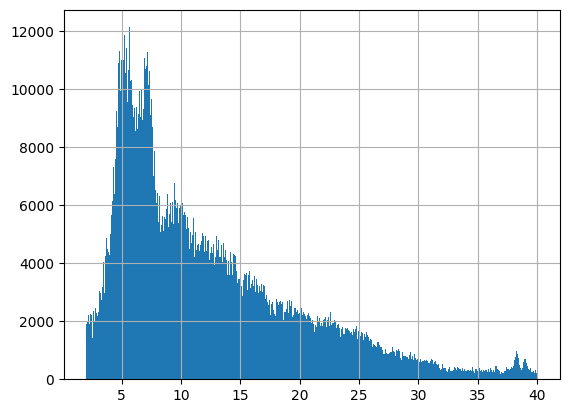

In [7]:
df2.speed.hist(bins=1000)

In [13]:
df.groupby('camera_location').size()

camera_location
I01    104539
I02    104521
I03    104813
I04    105080
I05    104126
I06    104102
I07    104116
I08    104216
T01    355124
T02    355114
T03    344956
T04    358685
T05    358640
T06    358641
T07    358671
T08    358658
T09    426472
T10    426180
T11    427740
T12    426528
T13    426166
T14    425921
T15    425969
T16    426008
dtype: int64

In [45]:
df2.to_csv('/data/jupiter/li.yu/data/halo_fps_cases/bedrock8013_202404_spark_engagements.csv', index=False)

### Search around birds / airborne debris images

In [55]:
df['serial_number'] = df.calibration_data__json.apply(lambda x: json.loads(x).get('serial_number', np.nan))
df['sn7'] = df['serial_number'].apply(lambda s: s[:7])
df['geohash6'] = df['geohash'].apply(lambda s: s[:6])
df['sn7'].unique(), df['geohash6'].unique()

(array(['PCE7T1B', 'PCE7T1A'], dtype=object),
 array(['9z1pg7', '9z1pgk', '9q9d4w', '9ufs6w', '9z1pgj', '9z1pgh',
        '9ufs6y', '9ufs6v', '9z1pg5', '9vg20v', '9ufs6x', '9ufs6z',
        '9ufs6t', '9zmt8e', '7zzzzz', '9zmt8d', '9q9d4z', '9ufsdg',
        '9ufsd7', '9ufsd8', '9q9d4x', '9q9d4y', '9ufsd2', '9ze3m3',
        '9ze3m7', '9ze3m9', '9ze3me', '9ze3m6', '9ze3md', '9ze3mk',
        '9ze3ms', '9zmt8s', '9z1pyy', '9z1pzm', '9z1pzn', '9z1ptw',
        '9z1pzq', '9z1pzj', '9ze3m2', '9yyzmd', '9yyzm8', '9yyzjr',
        '9yyzm9', '9ufsd3', '9ufsd1', '9ufsd6'], dtype=object))

In [57]:
sbdf = df[df.sn7 == 'PCE7T1B']
sbdf.shape

(9020603, 30)

In [56]:
df.to_csv('/data/jupiter/li.yu/data/halo_hard_cases/all_mcap_data_till_0418.csv', index=False)
# df.to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0326_v4.csv', index=False)

In [ ]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

In [5]:
import ast
root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_rgb_stereo_train_v6_2'
dataset = 'halo_rgb_stereo_train_v8_1'
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)

# ab_df = df[df.has_airborne == True]
# print(ab_df.shape, ab_df.iloc[0].geohash)
# ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])

df['Birds'] = df['label_counts'].apply(lambda d: d.get('Birds', 0))
df['has_birds'] = df['Birds'] > 0
bird_df = df[df.has_birds == True]
print(bird_df.shape, bird_df.iloc[0].geohash)
bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])

from jupiterdata.utils.dataset import query_db

(1362, 361) 9xjg9cde9btm


/tmp/ipykernel_103657/3024971100.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])


In [7]:
LEFT_CAMERAS = ('T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02')
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = []
for geohash_6 in bird_df.geohash_6.unique():
    collected_on_days = bird_df[(bird_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(bird_df[(bird_df.geohash_6 == geohash_6) & (bird_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500

        query = f"""
        SELECT
          IMJ.id AS id,
          IMJ.robot_name AS robot_name,
          IMJ.camera_location AS camera_location,
          IMJ.operating_field_name AS operating_field_name,
          IMJ.bag_name AS bag_name,
          IMJ.collected_on AS collected_on,
          IMJ.hard_drive_name AS hard_drive_name,
          IMJ.geohash AS geohash
        FROM
          mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
        WHERE
          collected_on LIKE '{collected_on_day[:10]}%'
          AND geohash LIKE '{geohash_6}%'
          AND camera_location IN {LEFT_CAMERAS}
        LIMIT {expand};
        """
        df = query_db(query)
        surround_ids += df.id.to_list()
        print(geohash_6, collected_on_day, current, len(df))
    #     break
    # break
    # print('queried geohash_6', geohash_6)

len(surround_ids)

9xjg9c 2023-08-04 13 57
9v5ks7 2023-08-02 153 50
9v5kwy 2023-08-05 2 375
9v5kxj 2023-08-07 20 50
9v5kse 2023-08-02 67 50
9xjg3z 2023-08-05 4 187
9v5kss 2023-08-02 32 50
dp03h5 2023-09-08 3 250
9v5ksk 2023-08-02 22 50
9xjgd0 2023-08-04 4 187
9xjgd0 2023-08-05 1 500
9xjgy5 2023-08-15 8 93
9v5kwu 2023-08-05 9 83
dp03ht 2023-09-09 1 500
9xjg9b 2023-08-04 5 150
9xjg9b 2023-08-05 2 375
9xjg92 2023-07-28 8 93
9xjepp 2023-08-09 2 375
dju21r 2023-08-18 2 375
9v5kxn 2023-08-07 7 107
9xjg3f 2023-08-07 5 150
9xjgy7 2023-08-15 2 375
9xjg8b 2023-08-17 4 187
dju21p 2023-08-18 4 187
9xjg98 2023-07-28 2 375
dp03k9 2023-09-13 3 250
9xjg64 2023-08-07 1 500
9xjg3d 2023-08-07 2 375
9xjgvu 2023-08-15 3 31
9v5kws 2023-08-07 2 375
9v5kwv 2023-08-05 19 50
9xjg9m 2023-08-16 5 150
dp03hx 2023-09-12 4 187
9xjg3r 2023-08-04 1 500
9xjg3r 2023-08-16 1 500
9v5ksd 2023-08-02 5 150
9xjer0 2023-08-09 1 500
dp03k0 2023-09-11 3 250
9v5ks6 2023-08-01 2 375
9v5ks6 2023-08-02 18 50
9xjg6p 2023-08-05 1 500
9xjg3g 2023-08-07 1

60573

In [8]:
remain_ids = list(set(surround_ids) - set(df.id.to_list()))
print(len(remain_ids))
remain_ids[0]

60073


'654658b46c228e535a897327'

### Search around a time

In [3]:
from datetime import datetime, timedelta
from jupiterdata.utils.dataset import query_db

In [36]:
terrain_csv = '/data/jupiter/li.yu/data/dune_simulation/representative_terrains.csv'
terrain_df = pd.read_csv(terrain_csv)
terrain_df['datetime'] = terrain_df.collected_on.apply(datetime.fromisoformat)
delta = timedelta(seconds=2)
print(terrain_df.shape)
terrain_df.head(2)

(15, 5)


,id,collected_on,bag_name,terrain,datetime
0,65eb4802738e53d66c8f346a,2024-02-08T19:22:19.435000,02_08_2024-19_22_27,open_field,2024-02-08 19:22:19.435
1,65fb4c39ae44446ff5d3fc19,2024-02-23T21:18:43.051000,02_23_2024-21_18_45,in_farm,2024-02-23 21:18:43.051


In [40]:
str(terrain_df.iloc[-1].datetime), str(terrain_df.iloc[-1].datetime + delta)[:19]

('2023-10-02 17:39:21.561000', '2023-10-02 17:39:23')

In [37]:
dfs = []
for i,row in terrain_df.iterrows():

    query = f"""
    SELECT
        IMJ.id AS id,
        IMJ.robot_name AS robot_name,
        IMJ.camera_location AS camera_location,
        IMJ.operating_field_name AS operating_field_name,
        IMJ.bag_name AS bag_name,
        IMJ.collected_on AS collected_on,
        IMJ.hard_drive_name AS hard_drive_name,
        IMJ.geohash AS geohash
    FROM
        mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
    WHERE
        bag_name = '{row.bag_name}'
        AND collected_on > '{str(row.datetime - delta)[:19]}'
        AND collected_on <= '{str(row.datetime + delta)[:19]}'
    """

    df = query_db(query)
    print(row.id, row.terrain, len(df))
    dfs.append(df)
    # break

65eb4802738e53d66c8f346a open_field 88
65fb4c39ae44446ff5d3fc19 in_farm 192
65eb1913abb27b5979bb2c49 trees 96
65fb5e03fbbd37ea5e01a225 pole_by_road 191
65fb3f89c7d378dbc65eb080 birds 192
6516a9ee59d4a80830b8f3f2 head_lands 32
64e5d2fd7d3e736bc96a7e64 tall_weeds 80
653b8ab65516ee030864597f irrigation 32
650420e64f21186e0f2bda70 road_side 44
655b1dfb1ec667f4ad177ea1 tall_weeds2 32
65fb3235e9fc675f8fee1f38 dust 192
654d7f53443a59d899337355 flooded_area 60
651f4ca5397e2827e807f262 head_lands2 18
6531b6fa44af03aa185c2c36 head_lands3 48
651f586e7747a76b7ba779a8 open_field2 32


In [38]:
df = df.sort_values('collected_on')
df[['id', 'collected_on']]

,id,collected_on
11,651f53a5d2dd50c6782fc604,2023-10-02 17:39:19.451000+00:00
20,651f53a8d7bd74435539150e,2023-10-02 17:39:19.487000+00:00
4,651f53a6f5298a1f9837649e,2023-10-02 17:39:19.513000+00:00
30,651f53aa4393288ab0595044,2023-10-02 17:39:19.523000+00:00
7,651f53ad1fc961b2c883145a,2023-10-02 17:39:19.528000+00:00
31,651f53b188a7ef1b7c505df2,2023-10-02 17:39:19.538000+00:00
18,651f53af24484d263bf73813,2023-10-02 17:39:19.545000+00:00
12,651f53ab66fd3736ba6d439d,2023-10-02 17:39:19.554000+00:00
5,651f57e52945e575a12a2c3a,2023-10-02 17:39:20.470000+00:00
24,651f57ec234278694e6702c2,2023-10-02 17:39:20.503000+00:00


In [41]:
df = pd.concat(dfs, ignore_index=True)
print(df.shape)

(1329, 8)


### Search around geohash and time

In [7]:
import ast
from datetime import datetime, timedelta
from jupiterdata.utils.dataset import query_db

def get_fn_geohash6_bag_name(root_dir, pred_dir, model, dataset):
    # load dataset df
    csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
    converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
    df = pd.read_csv(csv, converters=converters)
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    print(df.shape)

    # load pred fns
    sum_pred_dir = os.path.join(pred_dir, model, dataset, 'false_negative_sum5')
    fn_ids = os.listdir(sum_pred_dir)
    unique_ids = [f[:-4] for f in fn_ids]

    # get fn df
    fn_df = df[df.unique_id.isin(unique_ids)]
    return fn_df

In [25]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

(2101, 2) 1672 371


In [8]:
mcsv = '/data2/jupiter/datasets/halo_rgb_stereo_train_v8_1/master_annotations.csv'
mdf = pd.read_csv(mcsv)
print(mdf.shape)

root_dir = '/data/jupiter/datasets/safety_datasets/'
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
model = 'v81_nextvitsmall_dust_only_kore_dean_0406'
datasets = [
    "humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v10", 
    "humans/on_path_aft/on_path_aft_humans_night_2024_rev2_v10",
]
fn_dfs = [get_fn_geohash6_bag_name(root_dir, pred_dir, model, dataset) for dataset in datasets]
fn_df = pd.concat(fn_dfs, ignore_index=True)
print(fn_df.shape)
print(len(fn_df.bag_name.unique()), len(fn_df.geohash6.unique()))

(326871, 359)


/tmp/ipykernel_121511/3595870924.py:9: DtypeWarning: Columns (23,37,132,150,168,184,188,196,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, converters=converters)


(4251, 332)
(2260, 332)
(651, 333)
187 23


/tmp/ipykernel_121511/3595870924.py:9: DtypeWarning: Columns (164,165,172,174,184,213,218,219,222,224,239,273,274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, converters=converters)


In [9]:
g = fn_df.groupby(['geohash6', 'bag_name']).size()
keys = g.index
d = [[k, g[k]] for k in keys]
d = sorted(d, key=lambda k: k[1], reverse=True)
d[:5]

[[('9v6tpg', '02_14_2024-00_50_50'), 27],
 [('9zpund', '10_21_2023-00_44_44'), 17],
 [('9v6tps', '02_21_2024-01_24_00'), 16],
 [('9zsx7q', '11_06_2023-23_46_58'), 15],
 [('9v6tpg', '02_17_2024-01_35_37'), 14]]

In [14]:
# get collection time of fn images in a bag
def get_start_end_time_of_bag(fn_df, bag_name):
    # bag_name = '02_21_2024-01_24_00'
    bag_df = fn_df[fn_df.bag_name == bag_name]
    bag_df = bag_df.sort_values('collected_on')
    bag_df['datetime'] = bag_df.collected_on.apply(datetime.fromisoformat)
    delta = timedelta(seconds=60*30)
    # print(bag_df.shape)
    # print(bag_df.iloc[0].datetime, bag_df.iloc[-1].datetime)
    # print(bag_df.iloc[0].datetime - delta, bag_df.iloc[-1].datetime + delta)
    return bag_df.iloc[0].datetime - delta, bag_df.iloc[-1].datetime + delta

In [19]:
dfs = {}
for (geohash6, bag_name), N in d:
    t1, t2 = get_start_end_time_of_bag(fn_df, bag_name)

    query = f"""
    SELECT
        IMJ.id AS id,
        IMJ.robot_name AS robot_name,
        IMJ.camera_location AS camera_location,
        IMJ.operating_field_name AS operating_field_name,
        IMJ.bag_name AS bag_name,
        IMJ.collected_on AS collected_on,
        IMJ.hard_drive_name AS hard_drive_name,
        IMJ.geohash AS geohash
    FROM
        mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
    WHERE
        bag_name = '{bag_name}'
        AND collected_on > '{str(t1)[:19]}'
        AND collected_on <= '{str(t2)[:19]}'
    """

    df = query_db(query)
    print(geohash6, bag_name, t1, t2, len(df))
    dfs[(geohash6, bag_name)] = df
    # break

9v6tpg 02_14_2024-00_50_50 2024-02-14 00:21:43.138000 2024-02-14 01:22:19.165000 2078
9zpund 10_21_2023-00_44_44 2023-10-21 00:15:52.182000 2023-10-21 01:16:38.163000 921
9v6tps 02_21_2024-01_24_00 2024-02-21 00:54:22.037000 2024-02-21 01:54:43.033000 3377
9zsx7q 11_06_2023-23_46_58 2023-11-06 23:17:33.235000 2023-11-07 00:18:47.270000 1048
9v6tpg 02_17_2024-01_35_37 2024-02-17 01:06:00.170000 2024-02-17 02:07:00.095000 1616
9v6tpg 02_21_2024-01_02_22 2024-02-21 00:33:58.630000 2024-02-21 01:34:45.661000 2062
9v6tpg 02_24_2024-00_54_03 2024-02-24 00:24:42.477000 2024-02-24 01:25:06.534000 1459
9zmjkf 11_18_2023-02_58_58 2023-11-18 02:30:22.710000 2023-11-18 03:30:47.680000 960
9zmjkf 11_17_2023-23_45_45 2023-11-17 23:16:29.858000 2023-11-18 00:17:37.874000 921
9v6tpg 02_25_2024-01_27_28 2024-02-25 00:58:04.455000 2024-02-25 01:58:22.454000 959
9v6tpg 02_14_2024-00_52_52 2024-02-14 00:23:13.958000 2024-02-14 01:23:32.119000 1182
9v6tpg 02_14_2024-03_00_10 2024-02-14 02:30:58.970000 2024

In [40]:
total = 0
use_df = None
for (geohash6, bag_name), df in dfs.items():
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    # _df = df[(df.geohash6 != '7zzzzz') & (~df.geohash6.isin(geohash6_test_list))]
    _df = df[(~df.geohash6.isin(geohash6_test_list))]
    if len(_df) > 0:
        use_df = _df if len(_df) > 200 else use_df
        total += len(_df)
        print(geohash6, bag_name, _df.shape)
        print(_df.sample(min(5, len(_df))).id.to_list())
        # if len(_df[_df.id == '654bdc10851dd6051c9a2d4b']) > 0:
        #     print(_df[_df.id == '654bdc10851dd6051c9a2d4b'].geohash.to_list())
print(total)

9v6tpg 02_14_2024-00_50_50 (554, 9)
['65ea454263edec78ede83128', '65ea42b9936e32acd000c032', '65ea4a7c000669bb859209b4', '65ea482b71e1684babf8f77f', '65ea462bbf9244df1b4d852e']
9v6tps 02_21_2024-01_24_00 (904, 9)
['65e9cdab3de3d70fe449654b', '65ea0b36000669bb8591757d', '65e9d226e879f487a282a835', '65e9d004cafc4e811b02af3d', '65e9d12bf2f15c5f2ceaa879']
9zsx7q 11_06_2023-23_46_58 (88, 9)
['654bdc741094059fbafd8f00', '654bdc6334b229e20d4375a9', '654bdc2200210142b9092ba1', '654bdbd9fa83693bde13c334', '654bdc32f99b22029bd77dbb']
9v6tpg 02_17_2024-01_35_37 (445, 9)
['65e9c01ebc620c2c14fe4026', '65e9c0945e301af12dab0518', '65e9c12a2bbbdbae66cedae3', '65e9bdb5f04f29f44a32c6ab', '65e9c0784875033da61a0078']
9v6tpg 02_21_2024-01_02_22 (539, 9)
['65ea06aedb75a515c2d7ad48', '65e9ffc6459275487d44b70b', '65ea00ca6592f96a05175cee', '65ea01c0d80ab49742253a49', '65ea06f706198505e2a64568']
9v6tpg 02_24_2024-00_54_03 (396, 9)
['65e7c3694875033da61782fb', '65e7c80ddc04dc9d140eb419', '65e7c5a94875033da61787

In [41]:
use_df.geohash6.unique()

array(['7zzzzz'], dtype=object)

## Create a dataset

In [3]:
# df = pd.read_csv('/data/jupiter/li.yu/data/halo_hard_cases/20231219_20240119_halo_rgb_left_airborne.csv')
# df = pd.read_csv('/data/jupiter/li.yu/data/halo_fps_cases/bedrock40013_202406_spark_engagements.csv')
df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v10_0_raw_rgb_exist.csv')
# df = pd.read_csv('/data/jupiter/datasets/halo_failure_case_of_box_in_dust/selected_for_label.csv')
# df = pd.read_csv('/data/jupiter/datasets/halo_vehicles_in_dust_collection_march2024/selected_for_missing_label.csv')
# df = pd.read_csv('/data/jupiter/datasets/halo_human_in_dust_day_collection_may29/dust_on_lens_with_human.csv')
# df = pd.read_csv('/data2/jupiter/datasets/halo_fps_in_dust_candidates_stereo/selected_fps_in_dust.csv')
# df = pd.read_csv('/data/jupiter/datasets/dust_datasets/halo_dust_on_lens_blur_dataset_v3_20240807/v4_dedup_triaged.csv')
# df = pd.read_csv('/data/jupiter/datasets/dust_datasets/Jupiter_bedrock_40013_20240617_dust_sequences/dust_on_lens_with_human_v3.csv')
print(df.shape, 'id' in df, 'unique_id' in df)

(478264, 4) False True


In [6]:
df['id'] = df['unique_id'].apply(lambda d: d[:-8])

In [8]:
df2 = df[(df.raw_rgb_image_exist == False) | (df.raw_rgb_label_exist == False)]
print(df2.shape)
df3 = df2[df2.raw_rgb_dir_exist == False]
df3.shape

(10802, 5)


(3044, 5)

In [23]:
# dfs = []
dfs.append(df)
df2 = pd.concat(dfs, ignore_index=True)
df2.shape

(6195, 12)

In [11]:
# unlabeled dataset
Dataset.create(
    name="train_set_v10_0_missed_raw_images",
    description="3044 images to download for missed raw images/labels",
    kind='annotation',  # annotation or image
    image_ids=df3.id.to_list())

2024-08-11 07:15:39,045 - APIRequestor - ERROR - API error received | error_code : 400, error_message : {'message': "Missing request parameter: 'parameters or annotation_ids, Dataset kind: annotation'"}
ERROR:APIRequestor:API error received | error_code : 400, error_message : {'message': "Missing request parameter: 'parameters or annotation_ids, Dataset kind: annotation'"}


BadRequestError: {'message': "Missing request parameter: 'parameters or annotation_ids, Dataset kind: annotation'"}

In [12]:
# labeled, stereo dataset
imageids_to_dataset(
    image_ids=df3.id.to_list(),
    dataset_name="train_set_v10_0_missed_raw_images",
    dataset_description="3044 images to download for missed raw images/labels",
    dataset_kind='pixelwise_annotation',  # image or categorical_annotation or pixelwise_annotation
    mode='stereo',  # stereo or mono
    production_dataset=False,
)

ValueError: Number of processes must be at least 1

In [7]:
# imageids_to_dataset(
#     image_ids=test_df[test_df.camera_location.str.endswith('left')].id.to_list(),
#     dataset_name="20230823_labeled_right_images_12k_left_images_labels",
#     dataset_description="left images and labels of 20230823_labeled_right_images_12k",
#     dataset_kind='annotation',  # annotation or image
#     mode='mono',  # stereo or mono
#     camera_location=CORE_LEFT_CAMERAS,  # CORE_LEFT_CAMERAS or CORE_RIGHT_CAMERAS or ALL_CORE_CAMERAS
# )
# imageids_to_dataset(
#     image_ids=test_df[test_df.camera_location.str.endswith('right')].id.to_list(),
#     dataset_name="20230823_labeled_right_images_12k_right_images_labels",
#     dataset_description="right images and labels of 20230823_labeled_right_images_12k",
#     dataset_kind='annotation',  # annotation or image
#     mode='mono',  # stereo or mono
#     camera_location=CORE_RIGHT_CAMERAS,  # CORE_LEFT_CAMERAS or CORE_RIGHT_CAMERAS or ALL_CORE_CAMERAS
# )

## Download a dataset

In [45]:
# to download large image dataset and save in jpg format, change the following files
# note original files are ending with .bk, and changed files are ending with .save_jpg
# /home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/data/core/dataset.py
# /home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/util/aws/s3.py
# /home/li.yu/anaconda3/envs/brtdevkit/lib/python3.9/site-packages/brtdevkit/data/core/dataset.py  # save only one png file

In [17]:
dataset_name = 'halo_human_in_dust_night_collection_july29'
dataset_dir = os.path.join('/data/jupiter/datasets/dust_datasets', dataset_name)
# dataset_dir = os.path.join('/data2/jupiter/datasets', dataset_name)
# dataset_dir = os.path.join('/data/jupiter/li.yu/data', dataset_name)
# dataset_dir = os.path.join('/data/jupiter/datasets/image_quality_datasets', dataset_name)
os.makedirs(dataset_dir, exist_ok=True)

test_dataset = Dataset.retrieve(name=dataset_name)
test_df = test_dataset.to_dataframe()
test_dataset.download(dataset_dir, df=test_df)